In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import random
random.seed(135)
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
import pandas as pd
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data 

In [3]:
# generate data (features and costs)
m = 20 # number of nodes
n = 100 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
x, c = pyepo.data.tsp.genData(n+100, p, m+1, deg=deg, noise_width=0.5)

In [4]:
# demands
demands = np.random.rand(m) * 10
print(demands)

[1.60421985 5.4610857  0.62443351 6.46043145 2.18010974 5.1952663
 8.6725613  9.72775837 8.53955437 4.55030551 4.87533965 1.40802906
 7.53233711 0.27579093 4.85635581 9.09808187 9.37314946 2.48141017
 3.09683408 6.79130627]


## Build Graph

In [5]:
# opt model
vrpmodel = tsp_model = pyepo.model.grb.vrpModel(m+1, demands=demands, capacity=30, num_vehicle=5)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


In [6]:
# solve
vrpmodel.setObj(c[0])
sol, obj = vrpmodel.solve()
print("Obj: {:.4f}".format(obj))
route = vrpmodel.getTour(sol)
for tour in route:
    print(" -> ".join(map(str, tour)))

Obj: 52.5121
0 -> 1 -> 7 -> 3 -> 9 -> 4 -> 14 -> 0
0 -> 2 -> 6 -> 5 -> 18 -> 15 -> 10 -> 0
0 -> 11 -> 20 -> 19 -> 16 -> 0
0 -> 13 -> 12 -> 8 -> 17 -> 0


## Data Loader

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [8]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=100, random_state=246)

In [9]:
dataset_train = pyepo.data.dataset.optDataset(vrpmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(vrpmodel, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:51<00:00,  5.31s/it]


In [10]:
# get data loader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Linear Regression from PyTorch 

In [11]:
from torch import nn

In [12]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m+1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training

In [13]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [14]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)

In [15]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(vrpmodel, processes=1)

Num of cores: 1


In [16]:
# train mode
reg.train()
# init log
loss_log = []
# epochs
num_epochs = 200
# start traning
print("Start training...")
tbar = tqdm(range(num_epochs))
for epoch in tbar:
    # load data
    for data in loader_train:
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        tbar.set_description("Loss: {:.4f}".format(loss.item()))

Start training...


Loss: 0.2202: 100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [1:44:54<00:00, 31.47s/it]


In [17]:
# evaluate
mse = pyepo.metric.MSE(reg, loader_test)
print("Mean Squared Error: {:.4f}".format(mse))
regret = pyepo.metric.regret(reg, vrpmodel, loader_test)
print("Normalized Regret: {:.2f}%".format(regret * 100))

Mean Squared Error: 74.9423
Normalized Regret: 13.09%


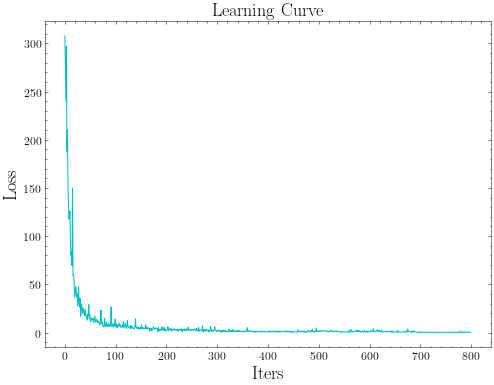

In [18]:
# draw plot
plt.figure(figsize=(8, 6))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Learning Curve", fontsize=18)
plt.show()